Importing scripts and packages

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scripts.dataloader import DataLoader
from scripts.trainer import Trainer
from scripts.knotselection import KnotSelection
from scripts.bspline import BSpline
from scripts.flow1d import Flow1d
from scripts.logittransform import LogitTransform
from scripts.flowcomposable1d import FlowComposable1d
from scripts.winespectra import WineSpectra
import torch.utils.data as data 
from torch.distributions.uniform import Uniform
from sklearn.metrics import mean_squared_error
from scripts.fdaplot import FdaPlot


Setting global seed for reproducibility

In [19]:
torch.manual_seed(10)


Loading Wine Spectra Dataset

In [20]:
#Load training and testing Wine Spectra Datasets:
dataloader = DataLoader()
x_train, x_test = dataloader.load_data()

Plotting the alcohol aborption as a function of the wave number

/Users/albert/Desktop/Fagprojekt/Fagprojekt2.0/scripts/fdaplot.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_n['time'] = self.time_df


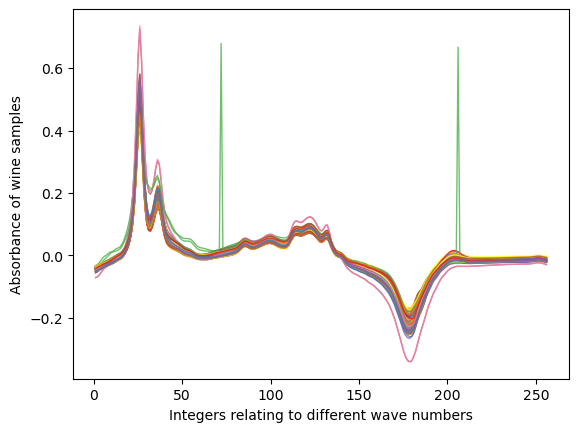

In [21]:
t_df_wine = np.arange(1, x_train.shape[1]+1)
df_plot_fda = FdaPlot(S_data = x_train, time_df=t_df_wine, n_sample=94)
df_plot_fda.plot()

Outlier was identified and removed from the training dataset

/Users/albert/Desktop/Fagprojekt/Fagprojekt2.0/scripts/fdaplot.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_n['time'] = self.time_df


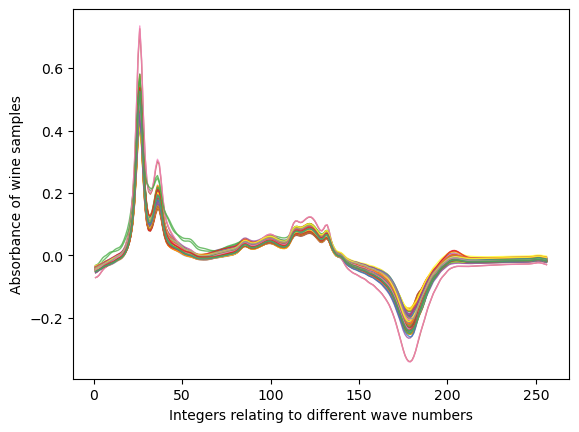

In [22]:
x_train2 = x_train.drop(83)
t_df_wine = np.arange(1, x_train2.shape[1]+1)
df_plot_fda = FdaPlot(S_data = x_train2, time_df=t_df_wine, n_sample=93)
df_plot_fda.plot()

Loading training and testing data as a dataloader with a batch size of 512

In [23]:
# #Flattening data arrays:
x_train, x_test = np.array(x_train2), np.array(x_test)
x_train = x_train.reshape((93*256,))
x_test = x_test.reshape((30*256, ))

#Defining training and testing sizes:
n_train, n_test = len(x_train), len(x_test)
print("n_train: ", n_train)
print("n_test: ", n_test)

#Setting dataloader seed for reproducibility
g = torch.Generator()
g.manual_seed(10)

train_loader = data.DataLoader(WineSpectra(x_train), batch_size=512, shuffle=True, generator=g)
test_loader = data.DataLoader(WineSpectra(x_test), batch_size=512, shuffle=True, generator=g)

n_train:  23808
n_test:  7680


Plotting training and testing data as histograms

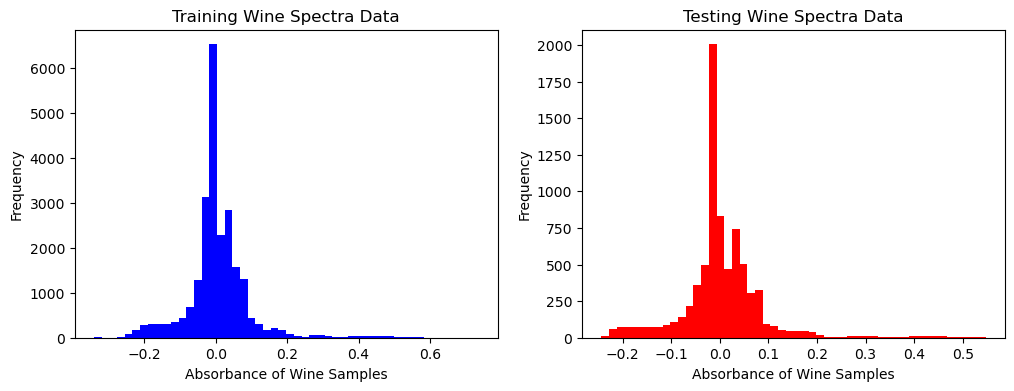

In [24]:
#Visualize training and testing data
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50, color = "blue")
_ = axes[1].hist(test_loader.dataset.array, bins=50, color = "red")
_ = axes[0].set_title('Training Wine Spectra Data')
_ = axes[1].set_title('Testing Wine Spectra Data')
_ = axes[0].set_xlabel('Absorbance of Wine Samples')
_ = axes[1].set_xlabel('Absorbance of Wine Samples')
_ = axes[0].set_ylabel('Frequency')
_ = axes[1].set_ylabel('Frequency')

Train the 1D Flows model where the target distribution is U(0,1)

In [25]:
#Defining the target distribution: 
target_distribution = Uniform(0.0, 1.0)

#Creating an instance of the Trainer class
Trainer = Trainer(target_distribution=target_distribution, train_loader=train_loader, test_loader=test_loader)

#Training the flow model for 300 epochs using a 0.003 learning weight and weight decay of 0
flow, train_losses, test_losses = Trainer.train_and_eval(300, 3e-3)

100%|██████████| 300/300 [06:06<00:00,  1.22s/it]


Plotting the training and testing loss functions as a function of the number of epochs

Text(0, 0.5, 'Loss')

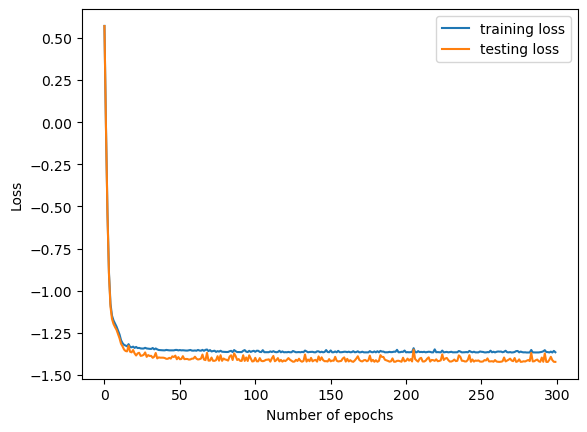

In [26]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='testing loss')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

Plotting the learned probability distribution of the Wine Spectra training dataset

Text(0, 0.5, 'p(x)')

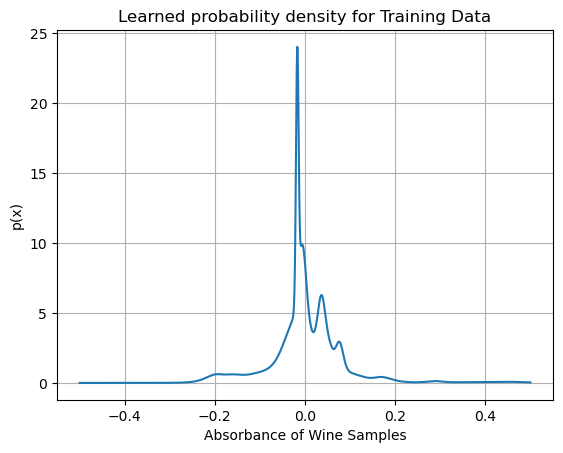

In [27]:
x = np.linspace(-0.5,0.5,1000)
with torch.no_grad():
    z_train, log_dz_by_dx_train = flow(torch.FloatTensor(x))
    px_train = (target_distribution.log_prob(z_train) + log_dz_by_dx_train).exp()

plt.grid()
plt.plot(x,px_train)
plt.title('Learned probability density for Training Data')
plt.xlabel('Absorbance of Wine Samples')
plt.ylabel('p(x)')




Plotting the learned target distribution

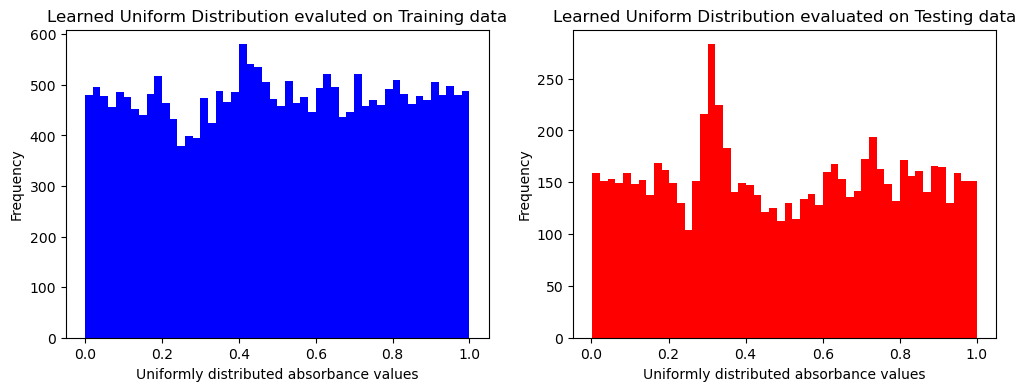

In [28]:
with torch.no_grad():
    z_train, log_dz_by_dx_train = flow(torch.FloatTensor(train_loader.dataset.array))
    px_train = (target_distribution.log_prob(z_train) + log_dz_by_dx_train).exp().cpu().numpy()

    z_test, log_dz_by_dx_test = flow(torch.FloatTensor(test_loader.dataset.array))
    px_test = (target_distribution.log_prob(z_test) + log_dz_by_dx_test).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(z_train, bins=50, color = "blue")
_ = axes[1].hist(z_test, bins=50, color = "red")
_ = axes[0].set_title('Learned Uniform Distribution evaluted on Training data')
_ = axes[1].set_title('Learned Uniform Distribution evaluated on Testing data')
_ = axes[0].set_xlabel('Uniformly distributed absorbance values')
_ = axes[1].set_xlabel('Uniformly distributed absorbance values')
_ = axes[0].set_ylabel('Frequency')
_ = axes[1].set_ylabel('Frequency')


Placing equally spaced knots on the learned Uniform distribution and transforming them back into the latent space of x

In [29]:
knotselection = KnotSelection(8, flow_model = flow, data = x_train2)
knots_z = np.linspace(0.22, 0.82, 8)
knots_z = [k for k in knots_z]
knots_x = knotselection.inverseflow(knots_z=knots_z)

Plotting the B-spline basis that will be used to project the Wine Spectra Dataset

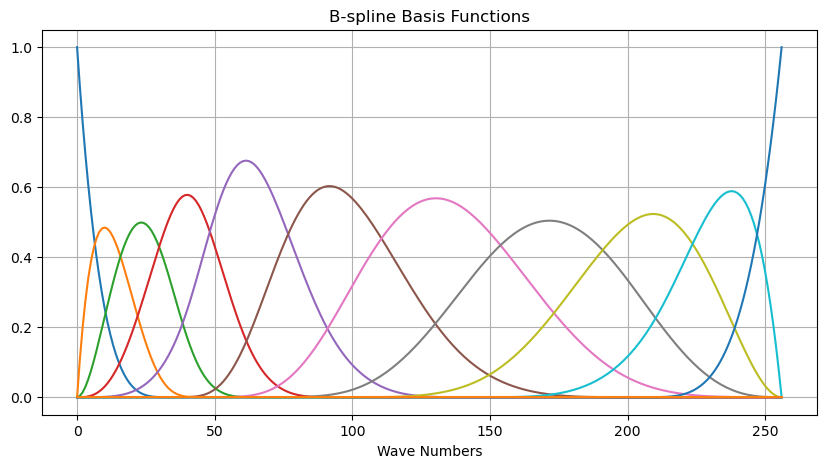

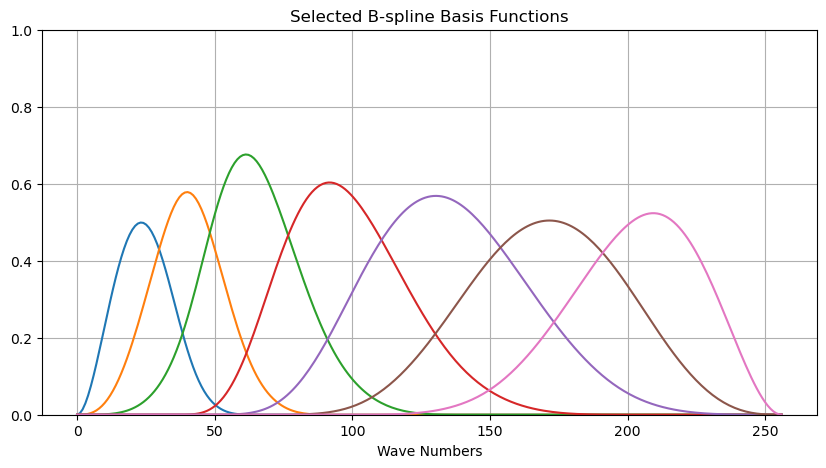

In [30]:
bspline = BSpline(knots_x, degree = 3)
B_full, xvals = bspline.bspline_basis()
x_wave = np.linspace(0, 256, 256)
plt.figure(figsize=(10, 5))
for i in range(B_full.shape[1]):
    plt.plot(x_wave, B_full[:, i], label=f"B{i}")
plt.title("B-spline Basis Functions")
plt.grid(True)
plt.xlabel('Wave Numbers')
plt.show()
B = B_full[:, 2:-3]  
plt.figure(figsize=(10, 5))
for i in range(B.shape[1]):
    plt.plot(x_wave, B[:, i], label=f"B{i}")
plt.title("Selected B-spline Basis Functions")
plt.grid(True)
plt.xlabel('Wave Numbers')
plt.ylim(0,1)
plt.show()

Projecting Wine Spectra onto B-splines constructed using equally spaced knots in the Uniform latent space

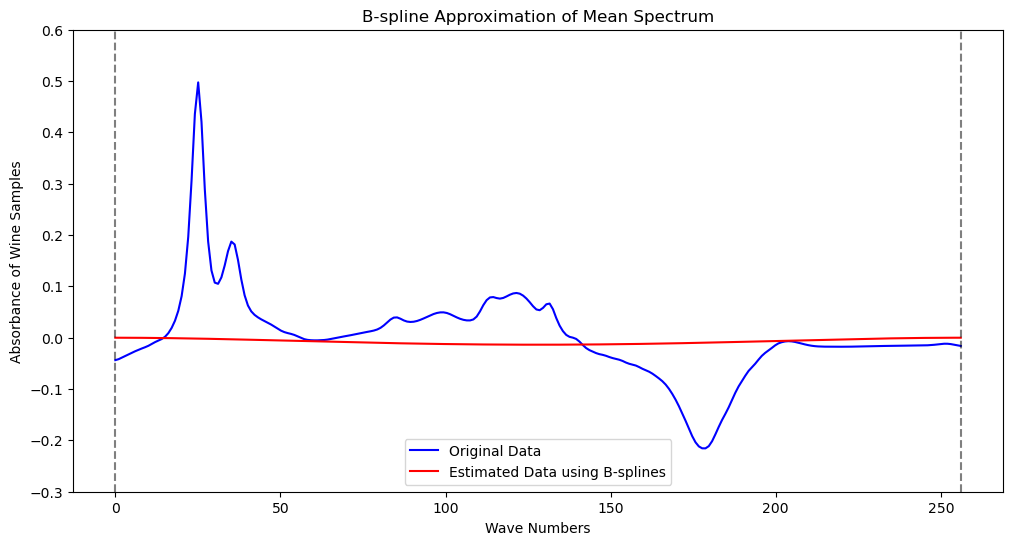

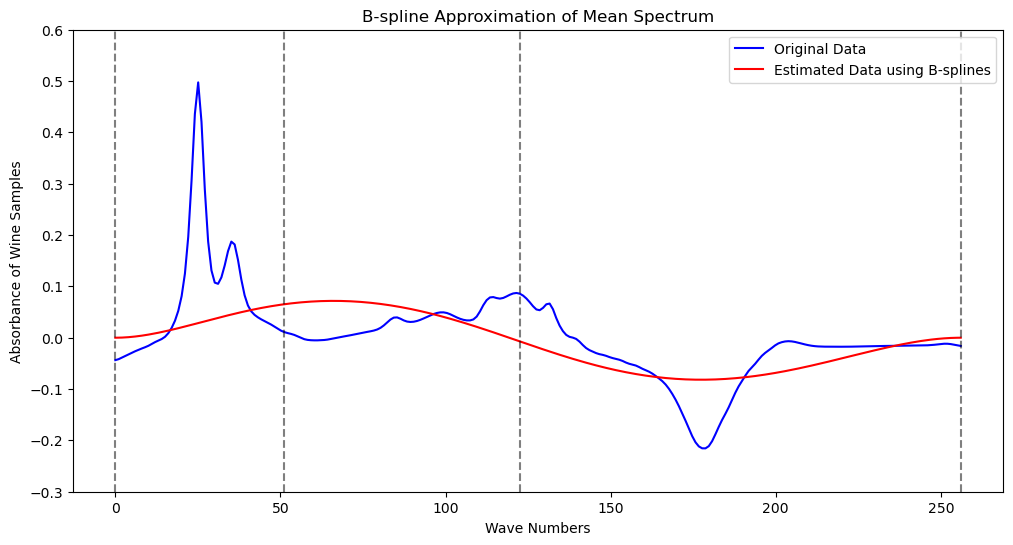

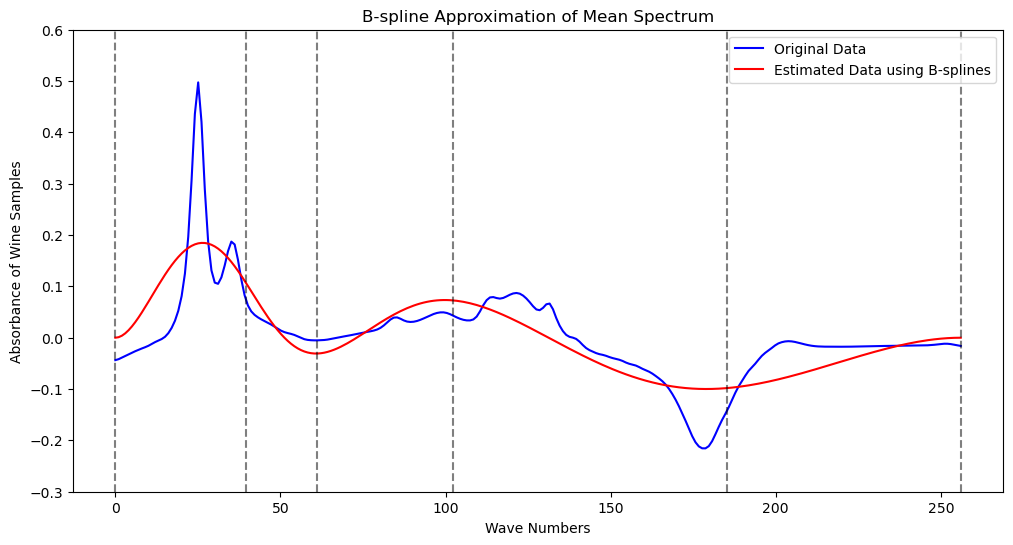

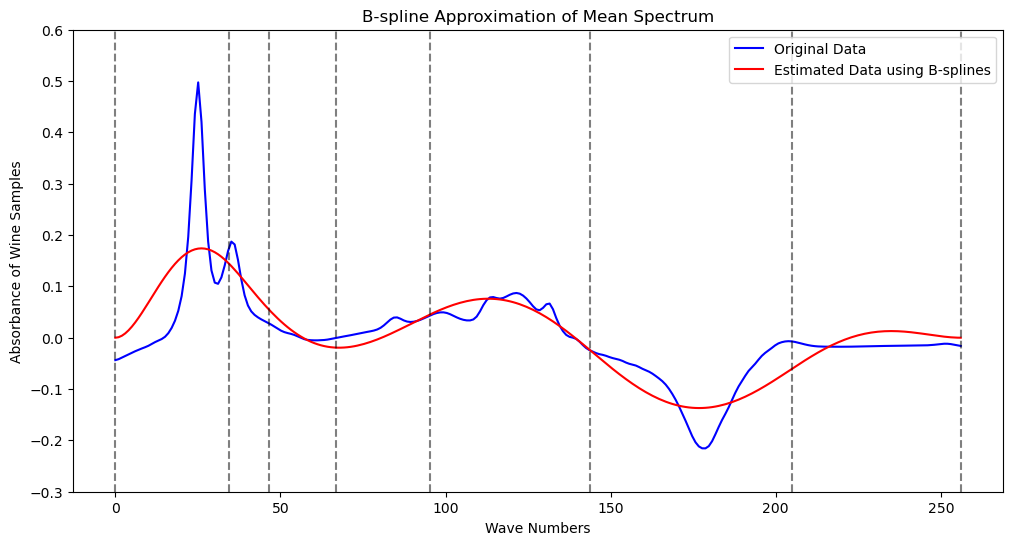

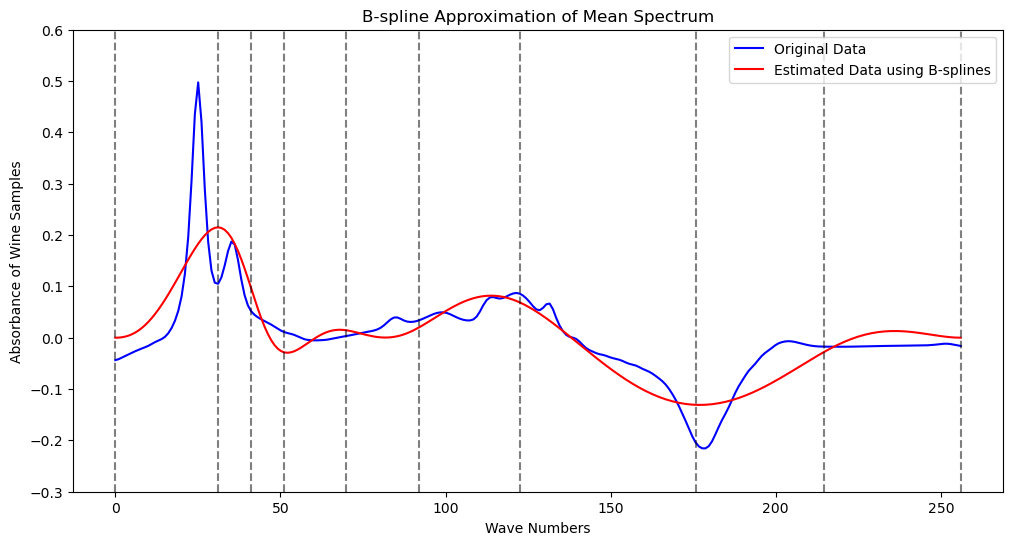

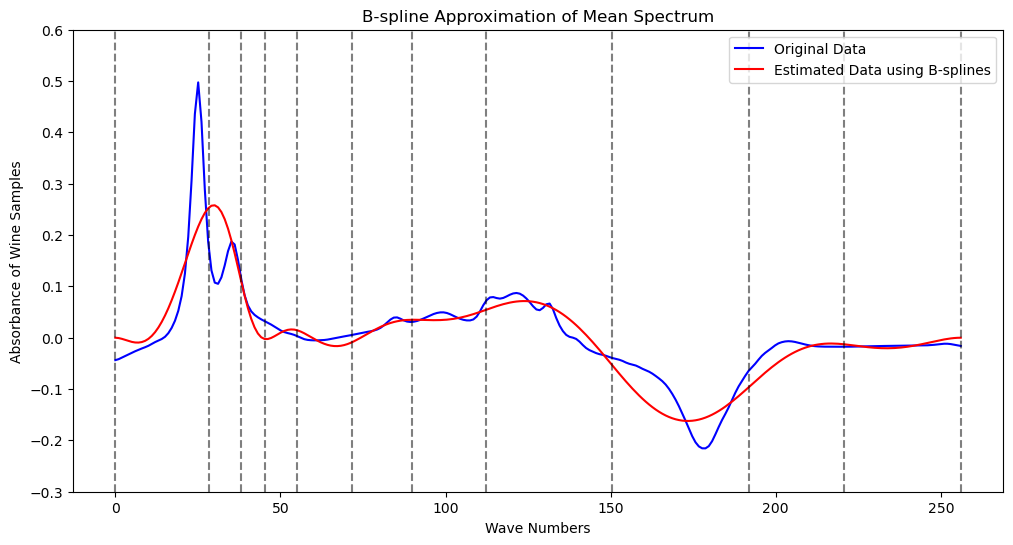

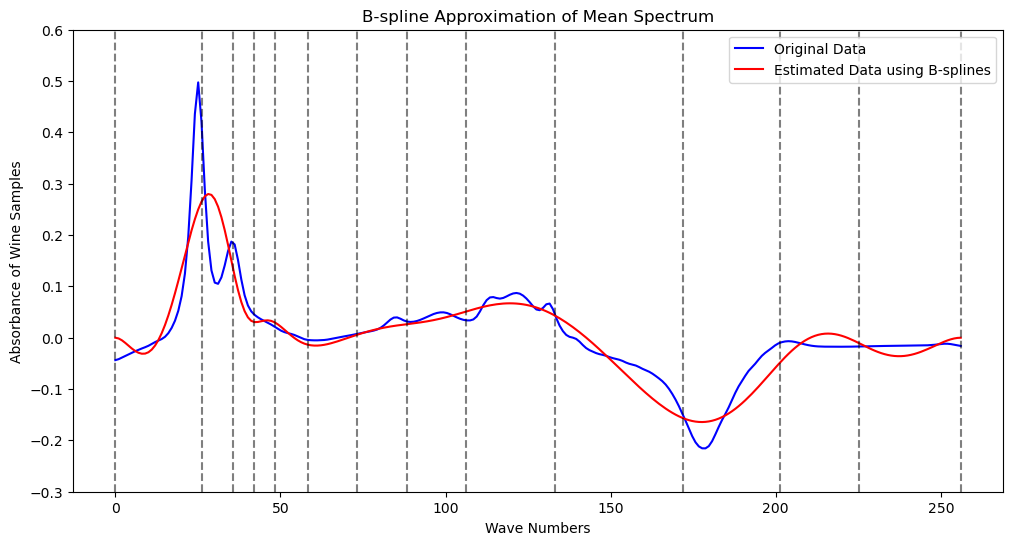

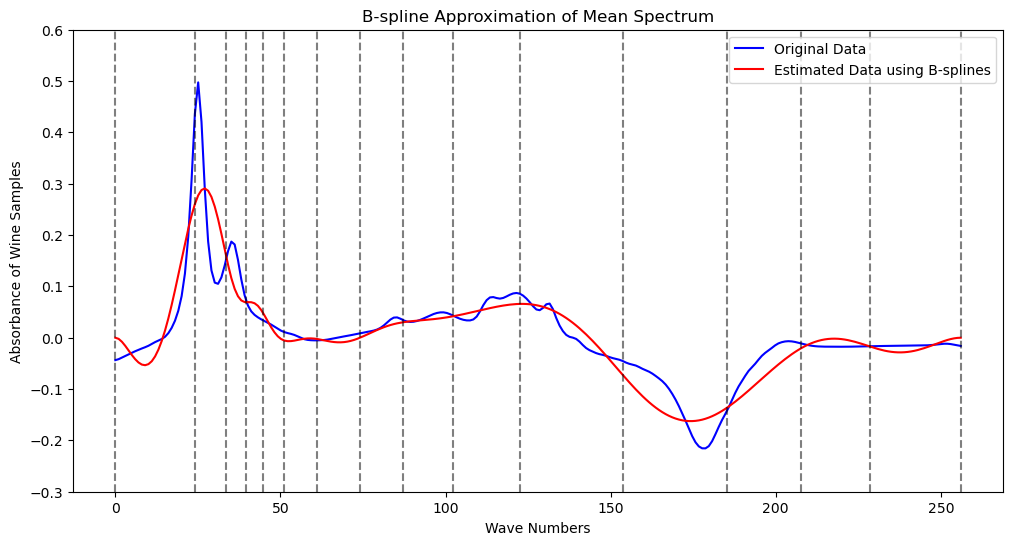

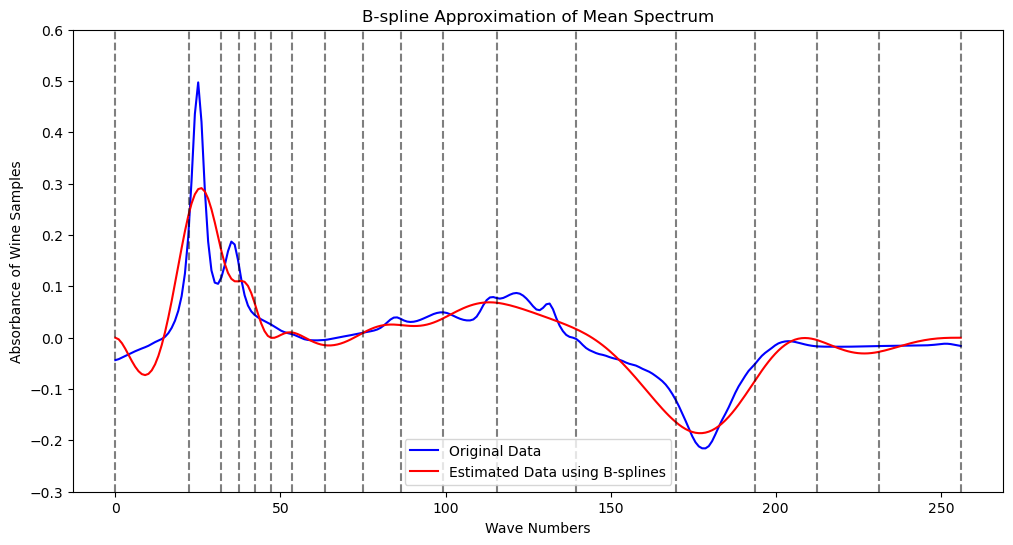

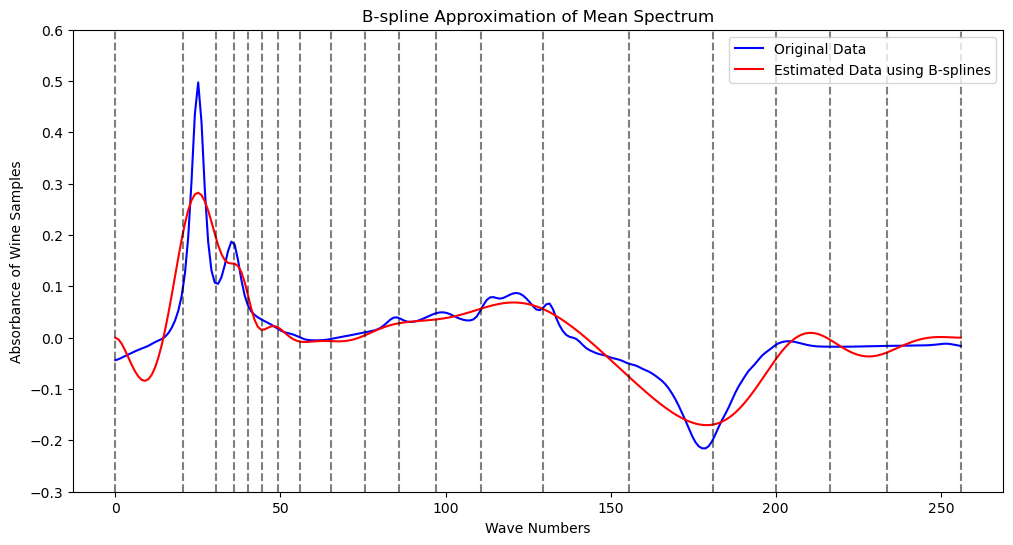

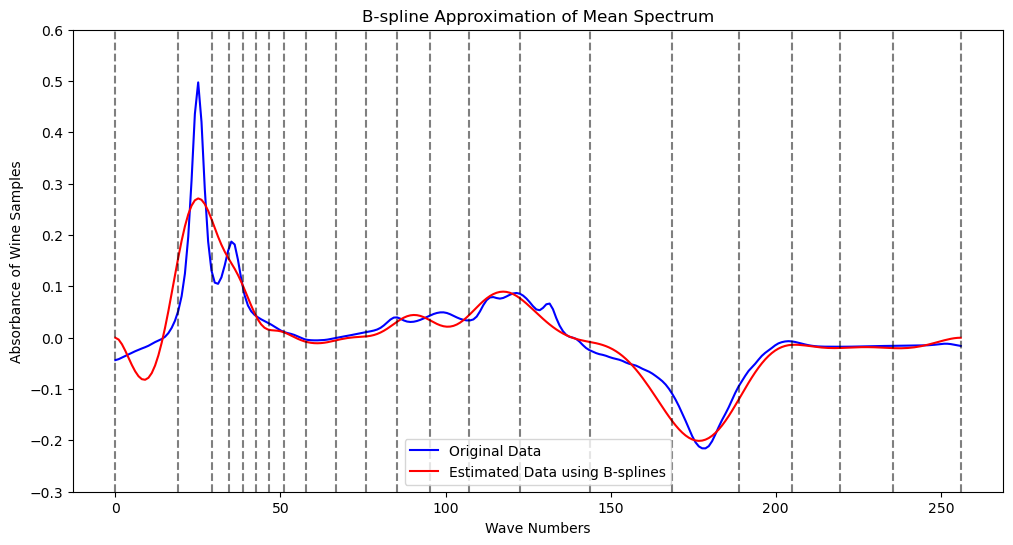

In [31]:
knots_interval = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
mse_vals = []
amse = []
for num_knots in knots_interval:
    knotselection = KnotSelection(num_knots, flow_model = flow, data = x_train2)
    knots_z = np.linspace(0.22, 0.82, num_knots)
    knots_z = [k for k in knots_z]
    knots_x = knotselection.inverseflow(knots_z=knots_z)
    bspline = BSpline(knots_x, degree = 3)
    B_full, xvals = bspline.bspline_basis()
    B = B_full[:, 2:-3]   
    y_values = x_train2
    mean_spectrum = np.mean(y_values, axis=0)
    coefficients = np.linalg.inv(B.T @ B + 0.001 * np.eye(B.shape[1])) @ B.T @ mean_spectrum
    y_est = B @ coefficients
    mse_knot = mean_squared_error(mean_spectrum, y_est)
    mse_vals.append(mse_knot)
    #Compute Average Mean Squared Error:
    amse_temp = []
    for index, row in x_train2.iterrows():
        y_values = row
        coefficients = np.linalg.inv(B.T @ B + 0.001 * np.eye(B.shape[1])) @ B.T @ y_values
        y_est = B @ coefficients
        mse = mean_squared_error(y_values, y_est)
        amse_temp.append(mse)
    amse.append(np.mean(amse_temp))
    plt.figure(figsize=(12, 6))
    x_wave = np.linspace(0, 256, 256)
    plt.plot(x_wave, mean_spectrum, label='Original Data', color = 'b'),
    plt.title('Mean Spectrum')
    plt.xlabel('Wave Numbers')
    plt.ylabel('Absorbance of Wine Samples')
    plt.plot(x_wave, y_est, label='Estimated Data using B-splines', color = 'r')
    knots_x_transformed = [(x + abs(min(knots_x))) / (abs(max(knots_x))+abs(min(knots_x))) * 256 for x in knots_x]
    for knot in knots_x_transformed:
        plt.axvline(x=knot, color='k', linestyle='--', alpha = 0.5)
    plt.title('B-spline Approximation of Mean Spectrum')
    plt.legend()
    plt.ylim(-0.3, 0.6)
    plt.xlabel('Wave Numbers')
    plt.ylabel('Absorbance of Wine Samples')
    plt.show()

Plotting the mean squared error as a function of the number of knots placed

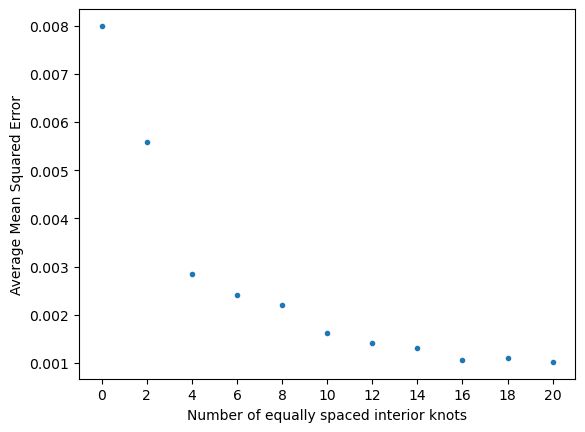

In [32]:
knots_interval = [x-2 for x in knots_interval]
plt.plot(knots_interval, amse, '.')
plt.xlabel("Number of equally spaced interior knots")
plt.ylabel("Average Mean Squared Error")
plt.xticks(knots_interval)
plt.show()

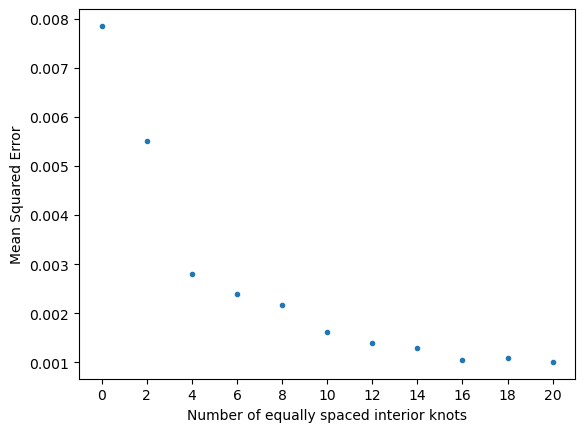

In [33]:
plt.plot(knots_interval, mse_vals, '.')
plt.xlabel("Number of equally spaced interior knots")
plt.ylabel("Mean Squared Error")
plt.xticks(knots_interval)
plt.show()

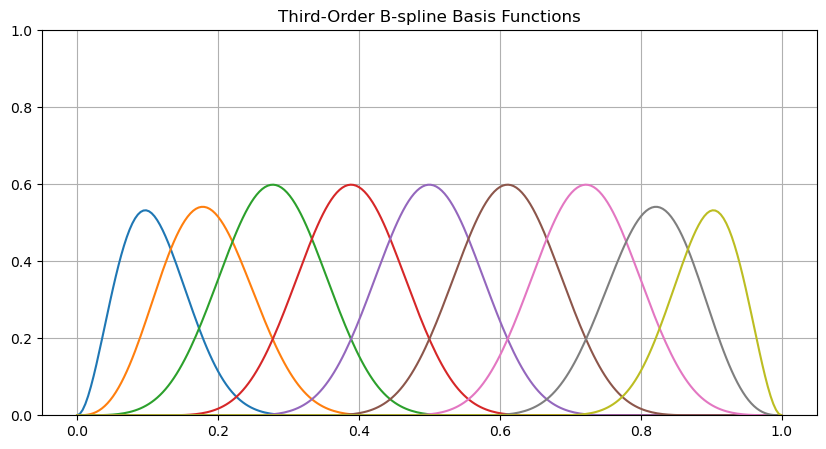

In [34]:
knots_x = np.linspace(0,1, 10)
knots_x = [x for x in knots_x]
bspline = BSpline(knots_x, degree = 3)
B_full, xvals = bspline.bspline_basis()
B = B_full[:, 2:-3]  
plt.figure(figsize=(10, 5))
for i in range(B.shape[1]):
    plt.plot(xvals, B[:, i], label=f"B{i}")
plt.title("Third-Order B-spline Basis Functions")
plt.grid(True)
plt.ylim(0,1)
plt.show()
